In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

from joblib import load, dump

In [2]:
with pd.HDFStore('out/ModelData.20160529.h5') as cstore:
    df = cstore['last_author']

In [3]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

sns.set_context("poster")
sns.set_style("ticks")

In [4]:
def logit(p):
    return np.log(p/(1-p))


def get_empirical_logit(df, X_col, y_col, conditioning_var="Gender",
    bins=None, testing=False):
    if testing:
        # If testing the just print X and y columns
        print X_col, y_col
        return conditioning_var, ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print X_col, conditioning_var, y_col
    t = df.pivot_table(index=pd.cut(df[X_col], bins=bins),
      columns=conditioning_var, values=y_col,
      aggfunc=[np.mean, len])
    t = t.set_index(bins[1:])
    return t


def logistic(x):
    return 1. / (1. + np.exp(-x))

In [5]:
results_full = load("results_all_model/%s/results_all_model_intercept.%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX))
TOP_FEATURES = map(lambda x: x[0][0], results_full)

feature_dict = {
	"Intercept": [u'Intercept',],
	"Gender": [
		u'C(gender, levels=GENDERS)[T.F]',
		u'C(gender, levels=GENDERS)[T.M]',
		],
	"Affiliation": [
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]',
	],
	"Ethnicity": [
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[8]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[10]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[12]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[13]',
	],
	"AuthorAge": [
		u'I(auth_prev_papers == 0)[T.True]',
		u'I(auth_prev_papers == 1)[T.True]',
		u'np.log10(auth_prev_papers + 1)',
		u'I(np.log10(auth_prev_papers + 1) ** 2)',
	],
	"SourceCites": [
		u'I(source_ncites == 1)[T.True]',
		u'np.log10(source_ncites)',
		u'I(np.log10(source_ncites) ** 2)',
		u'I(np.log10(source_ncites) ** 3)',        
	],
	"SourceAuthors": [
		u'I(source_n_authors > 20)[T.True]',
		u'np.log10(np.clip(source_n_authors, 0, 20))',
		u'I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)',
	],
	"MeshCounts": [
		u'I(source_n_mesh_ex == 0)[T.True]',
		u'I(sink_n_mesh_ex == 0)[T.True]',
		u'np.log10(source_n_mesh_ex + 1)',
		u'np.log10(sink_n_mesh_ex + 1)',
	],
	"Journal": [
		u'journal_same[T.True]',
		u'I(jj_sim == 0)[T.True]',
		u'np.log10(jj_sim + 1)',
		u'I(np.log10(jj_sim + 1) ** 2)',
	],
	"YearSpan": [
		u'I(year_span < 0)[T.True]',
		u'I(year_span == 0)[T.True]',
		u'mf.score_log_1(year_span)',
		u'I(mf.score_log_1(year_span) ** 2)',
	],
	"SinkCites": [
		u'I(sink_prev_ncites == 0)[T.True]',
		u'np.log10(sink_prev_ncites + 1)',
		u'I(np.log10(sink_prev_ncites + 1) ** 2)',
	],
	"PubType": [
		u'source_is_journal[T.True]',
		u'source_is_review[T.True]',
		u'source_is_case_rep[T.True]',
		u'source_is_let_ed_com[T.True]',
		u'sink_is_journal[T.True]',
		u'sink_is_review[T.True]',
		u'sink_is_case_rep[T.True]',
		u'sink_is_let_ed_com[T.True]',
	],
	"Language": [
		u'source_is_eng[T.True]',
		u'sink_is_eng[T.True]',
	],
	"VolumeNovelty": [
		u'np.log10(np.nan_to_num(source_V_novelty) + 1)',
		u'np.log10(np.nan_to_num(sink_V_novelty) + 1)',
		u'I(np.log10(np.nan_to_num(sink_V_novelty) + 1) ** 2)'
	]
}


feature_short_codes={
    "AuthorAge": "PC",
    "Gender": "G",
    "Affiliation": "CA",
    "Ethnicity": "E",
    "SourceCites": "NR",
    "SourceAuthors": "NA",
    "MeshCounts": "MC",
    "YearSpan": "YS",
    "SinkCites": "CC",
    "Journal": "J",
    "Language": "L",
    "PubType": "P",
    "VolumeNovelty": "N",
    "Intercept": "O"
}

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file 'results_all_model/v4/results_all_model_intercept.v4.last_author.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':


In [6]:
store_path, X_df_path, y_df_path = ("out/Model.%s.h5" % MODEL_SUFFIX), "X", "y"

In [7]:
results_full[-1][0][1][1].tables[1].index

Index([u'Intercept', u'I(year_span < 0)[T.True]', u'I(year_span == 0)[T.True]',
       u'mf.score_log_1(year_span)', u'I(mf.score_log_1(year_span) ** 2)',
       u'I(auth_prev_papers == 0)[T.True]',
       u'I(auth_prev_papers == 1)[T.True]', u'np.log10(auth_prev_papers + 1)',
       u'I(np.log10(auth_prev_papers + 1) ** 2)', u'source_is_journal[T.True]',
       u'source_is_review[T.True]', u'source_is_case_rep[T.True]',
       u'source_is_let_ed_com[T.True]', u'sink_is_journal[T.True]',
       u'sink_is_review[T.True]', u'sink_is_case_rep[T.True]',
       u'sink_is_let_ed_com[T.True]', u'journal_same[T.True]',
       u'I(jj_sim == 0)[T.True]', u'np.log10(jj_sim + 1)',
       u'I(np.log10(jj_sim + 1) ** 2)', u'I(sink_prev_ncites == 0)[T.True]',
       u'np.log10(sink_prev_ncites + 1)',
       u'I(np.log10(sink_prev_ncites + 1) ** 2)',
       u'I(source_ncites == 1)[T.True]', u'np.log10(source_ncites)',
       u'I(np.log10(source_ncites) ** 2)', u'I(np.log10(source_ncites) ** 3)',
     

In [8]:
X = pd.read_hdf(store_path, key=X_df_path, columns=results_full[-1][0][1][1].tables[1].index.tolist())

In [9]:
W = results_full[-1][0][1][1].tables[1]["Coef."]
W.values

array([ -2.78974627e+00,  -3.83345846e-01,   7.34997999e-01,
         1.23166674e+00,  -1.40187024e+00,  -1.23161593e+00,
        -1.87440754e-01,   2.17160495e+00,  -3.40216459e-01,
         2.29151848e-01,  -2.48884701e-01,  -9.47638479e-01,
        -3.43292492e-01,   3.23796540e-01,  -6.40837144e-01,
        -7.31334653e-01,  -2.92140032e-01,   5.34377223e-01,
        -2.96090534e-01,   1.26127472e-01,  -4.98766438e-02,
         2.39917220e-01,  -7.88843533e-02,  -1.68682023e-01,
        -4.04565035e-01,  -2.22093488e+00,   1.46327830e+00,
        -3.87037175e-01,  -1.58490498e-01,  -8.96478549e-02,
        -9.24638745e-02,  -1.68671061e-01,  -1.16278492e-01,
        -2.97869360e-01,  -6.86258915e-02,  -4.31893815e-01,
        -9.88803025e-02,  -1.83973044e-01,  -1.79261237e-01,
        -8.33411814e-02,  -2.05831207e-01,  -2.12596933e-01,
        -1.38890699e-01,   4.82252755e-02,  -2.21268539e-02,
        -5.01999415e-02,  -4.43672644e-01,   6.64947629e-02,
         7.00522421e-01,

In [10]:
X.columns == W.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [11]:
X.values.shape, W.shape

((41618369, 70), (70,))

In [12]:
y_pred_logit = np.dot(W, X.values.T)

In [13]:
y_pred = logistic(y_pred_logit)

In [14]:
y_pred.max(), y_pred.min()

(0.8557690318515615, 6.7910062720855437e-07)

In [15]:
df.columns

Index([u'source_id', u'source_year', u'source_n_mesh', u'source_n_mesh_ex',
       u'source_is_eng', u'source_country', u'source_is_journal',
       u'source_is_review', u'source_is_case_rep', u'source_is_let_ed_com',
       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
       u'source_PV_novelty', u'source_ncites', u'source_n_authors', u'sink_id',
       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors', u'year_span',
       u'journal_same', u'mesh_sim', u'title_sim', u'lang_sim',
       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
       u'gender_sim', u'eth_sim', u'n_common_authors', u'gender', u'eth1',
       u'eth2', u'pos', u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_last_npapers', u'auth_prev_papers', u'jj_

In [16]:
df["predicted_prob"] = y_pred
df["predicted_logit"] = y_pred_logit

In [17]:
y_feature_col = ["is_self_cite", "predicted_prob"]
xcols = ["auth_prev_papers", "sink_prev_ncites", 
         "source_V_novelty", "sink_n_mesh_ex", "jj_sim",
         "year_span", "source_ncites", "source_n_authors"]
bins = np.array([-0.1] + range(1000))

In [18]:
"""
t = get_empirical_logit(df, xcols[0], y_feature_col,
    conditioning_var="gender",
    bins=bins,
    testing=False)

"""
bins = np.array(range(10) + range(100,10000,100))
t = df.pivot_table(index=pd.cut(df[xcols[2]], bins=bins),
      values=y_feature_col,
      aggfunc=[np.mean, len])
t = t.set_index(bins[1:])


(-2.6989835069633683, -1.939228002115527)

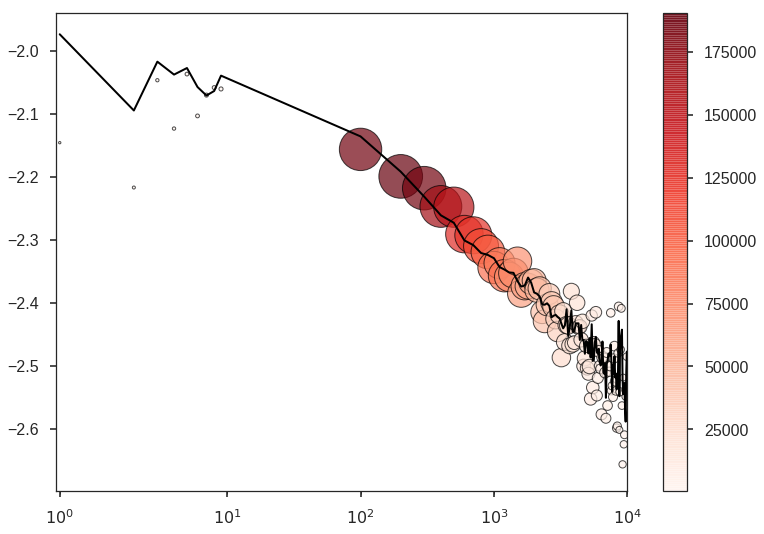

In [19]:
scp = plt.scatter(t.index, logit(t["mean"]["is_self_cite"]), edgecolor="black",
            s=t["len"]["is_self_cite"]/ 1e3,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = plt.cm.get_cmap("Reds"),
            alpha=0.7, linewidth=1, marker="o")
plt.plot(t.index, logit(t["mean"]["predicted_prob"]), linestyle="-", color="k", lw=2, alpha=1)
cb = plt.colorbar(scp)
plt.xscale("symlog")
plt.xlim([0.95,10000])
#plt.ylim([-3.1,-2.7])
plt.ylim(None)

sink_prev_ncites symlog [-0.1, 101] None
sink_prev_ncites None ['is_self_cite', 'predicted_prob']
auth_prev_papers symlog [-0.1, 101] None
auth_prev_papers None ['is_self_cite', 'predicted_prob']
year_span symlog [-1.1, 51] None
year_span None ['is_self_cite', 'predicted_prob']
jj_sim linear [-0.1, 101] None
jj_sim None ['is_self_cite', 'predicted_prob']
source_ncites log [0.9, 201] None
source_ncites None ['is_self_cite', 'predicted_prob']
source_V_novelty log [0.95, 10000] None
source_V_novelty None ['is_self_cite', 'predicted_prob']
source_n_authors linear [0.5, 21] None
source_n_authors None ['is_self_cite', 'predicted_prob']
sink_n_mesh_ex linear [-1, 100] None
sink_n_mesh_ex None ['is_self_cite', 'predicted_prob']


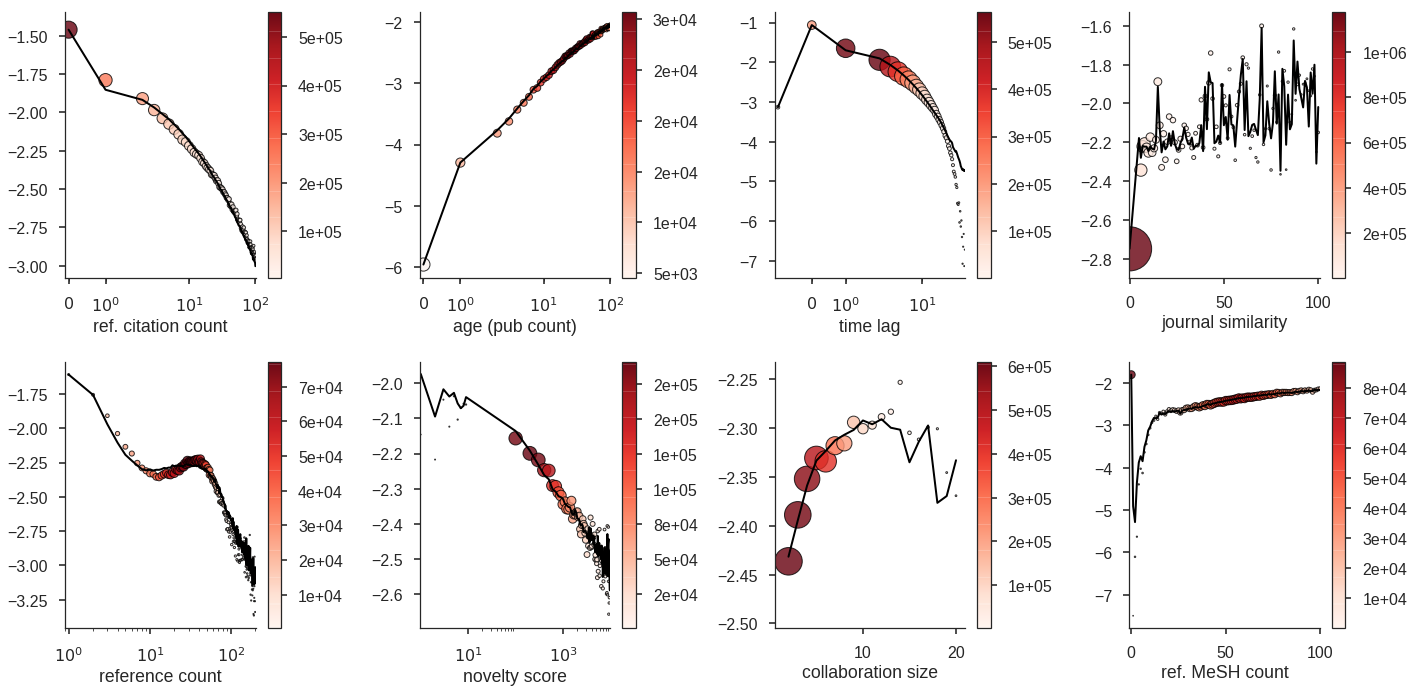

In [20]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('Reds')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4, figsize=(20,10))
ax = ax.flatten()
plot_id = 0


# NEW PARAMS
plot_params_dict = {
    "auth_prev_papers": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], None, "age (pub count)"],
    "sink_prev_ncites": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], None, "ref. citation count"],
    "source_V_novelty": [np.array(range(10) + range(100,10000,100)), "log", [0.95, 10000], None, "novelty score"],
    "sink_n_mesh_ex": [np.array([-0.1] + range(101)), "linear", [-1, 100], None, "ref. MeSH count"],
    "jj_sim": [np.array([-0.1,0] + range(5,101)), "linear", [-0.1, 101], None, "journal similarity"],
    "year_span": [np.array([-10, -1] + range(51)), "symlog", [-1.1, 51], None, "time lag"],
    "source_ncites": [np.array([-1] + range(201)), "log", [0.9, 201], None, "reference count"],
    "source_n_authors": [np.array([-0.1] + range(21)), "linear", [0.5,21], None, "collaboration size"]
}

y_feature_col = ["is_self_cite", "predicted_prob"]
xcols = ["sink_prev_ncites", "auth_prev_papers", "year_span", "jj_sim",
         "source_ncites", "source_V_novelty", "source_n_authors", "sink_n_mesh_ex"]
for k in xcols:
    bins, xscale, xlims, ylims, xlbl = plot_params_dict[k]
    print k, xscale, xlims, ylims
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var=None,
    bins=bins,
    testing=False)
    #lgd_items = []
    scp = ax[plot_id].scatter(t.index, logit(t["mean"]["is_self_cite"]),
            edgecolor="black",
            s=t["len"]["is_self_cite"]/ 1e4,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = cm, alpha=0.8, linewidth=1, marker="o")
    #yidx = ((t.index >= xlims[0]) & (t.index <= xlims[1]))
    #line, = ax[plot_id].plot(t[yidx].index, logit(t[yidx]["mean"]["predicted_prob"]), linestyle="-", color="r", lw=2, alpha=1)
    line, = ax[plot_id].plot(
        t.index, logit(t["mean"]["predicted_prob"]), linestyle="-", color="k", lw=2, alpha=1)
    #ylims = [logit(t[yidx]["mean"]["is_self_cite"]).min(), logit(t[yidx]["mean"]["is_self_cite"]).max()]
    #lgd_items.append(line)
    cb = plt.colorbar(scp, ax = ax[plot_id], format='%.0e')
    ax[plot_id].set_xlabel(xlbl)
    #ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim(ylims)
    # Hide the right and top spines
    ax[plot_id].spines['right'].set_visible(False)
    ax[plot_id].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax[plot_id].yaxis.set_ticks_position('left')
    ax[plot_id].xaxis.set_ticks_position('bottom')
    plot_id += 1
plt.margins(0.1)
#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
"""
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
"""
fig.tight_layout()
plt.savefig("Empirical_vs_Fit_1.%s.pdf" % MODEL_SUFFIX)

# Decripting stats

In [21]:
(df.is_self_cite == 1).value_counts()

False    38018959
True      3599410
Name: is_self_cite, dtype: int64

In [22]:
df.shape

(41618369, 56)

In [23]:
3599410. * 100 / 41618369

8.648608983211236

## V5 Model

Add square term to author age

In [25]:
import model_functions as mf

MF reloaded 1


In [26]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ I(source_ncites == 1) + np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
print X.shape, y.shape

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
(41618369, 70) (41618369, 1)


In [27]:
model = Logit(y,X)
res = model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.257891
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
======================================================================================================================
Model:                                Logit                            Pseudo R-squared:                 0.124        
Dependent Variable:                   is_self_cite                     AIC:                              21466123.2504
Date:                                 2016-06-11 13:40                 BIC:                              21467211.3341
No. Observations:                     41618369                         Log-Likelihood:                   -1.0733e+07  
Df Model:                             69                               LL-Null:                          -1.2250e+07  
Df Residuals:                         41618299                         LLR p-value:                      0.0000       
Converged:                            1.0000                           Scale:                            1.0000       
No. Iterations:                       10.0000                                                                         
----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -2.7897   0.0267 -104.3132 0.0000 -2.8422 -2.7373
I(auth_prev_papers == 0)[T.True]                                     -1.2316   0.0164  -75.1366 0.0000 -1.2637 -1.1995
I(auth_prev_papers == 1)[T.True]                                     -0.1874   0.0106  -17.7109 0.0000 -0.2082 -0.1667
C(gender, levels=GENDERS)[T.F]                                        0.0260   0.0029    8.8682 0.0000  0.0203  0.0318
C(gender, levels=GENDERS)[T.M]                                       -0.0024   0.0026   -0.9370 0.3487 -0.0075  0.0027
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.1585   0.0052  -30.4146 0.0000 -0.1687 -0.1483
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0896   0.0024  -37.7729 0.0000 -0.0943 -0.0850
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                  -0.0925   0.0060  -15.2884 0.0000 -0.1043 -0.0806
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                -0.1687   0.0031  -55.1056 0.0000 -0.1747 -0.1627
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.1163   0.0038  -30.4387 0.0000 -0.1238 -0.1088
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.2979   0.0049  -61.0808 0.0000 -0.3074 -0.2883
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0686   0.0030  -22.6150 0.0000 -0.0746 -0.0627
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.4319   0.0073  -59.1600 0.0000 -0.4462 -0.4176
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]              -0.0989   0.0040  -24.4569 0.0000 -0.1068 -0.0910
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.1840   0.0049  -37.6312 0.0000 -0.1936 -0.1744
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]            -0.1793   0.0052  -34.4466 0.0000 -0.1895 -0.1691
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                 -0.0833   0.0050  -16.7425 0.0000 -0.0931 -0.0736
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.2058   0.0081  -25.5236 0.0000 -0.2216 -0.1900
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                  -0.2126   0.0021 -103.5117 0.0000 -0.2166 -0.2086
I(source_ncites == 1)[T.True]                                        -0.4046   0.0208  -19.4583 0.0000 -0.4453 -0.3638
I(source_n_authors > 20)[T.True]                                     -0.0502

In [28]:
W = res.summary2().tables[1]["Coef."]
W.values

array([ -2.78974627e+00,  -1.23161593e+00,  -1.87440754e-01,
         2.60231245e-02,  -2.43379383e-03,  -1.58490498e-01,
        -8.96478549e-02,  -9.24638745e-02,  -1.68671061e-01,
        -1.16278492e-01,  -2.97869360e-01,  -6.86258915e-02,
        -4.31893815e-01,  -9.88803025e-02,  -1.83973044e-01,
        -1.79261237e-01,  -8.33411814e-02,  -2.05831207e-01,
        -2.12596933e-01,  -4.04565035e-01,  -5.01999415e-02,
        -8.92221533e-01,   4.62749261e-03,  -3.83345846e-01,
         7.34997999e-01,   2.39917220e-01,  -2.96090534e-01,
         5.34377223e-01,   7.00522421e-01,   2.29151848e-01,
        -2.48884701e-01,  -9.47638479e-01,  -3.43292492e-01,
        -3.07901026e-02,   3.23796540e-01,  -6.40837144e-01,
        -7.31334653e-01,  -2.92140032e-01,   2.17160495e+00,
        -3.40216459e-01,   6.19749721e-02,   8.15610121e-02,
         3.43330997e-02,  -4.81603609e-02,   3.24395724e-02,
        -3.75468257e-02,   2.56053999e-02,   2.01633057e-02,
         7.00549432e-02,

In [29]:
X.values.shape, W.shape

((41618369, 70), (70,))

In [30]:
y_pred_logit = np.dot(W, X.values.T)
y_pred = logistic(y_pred_logit)
y_pred.max(), y_pred.min()

(0.85576903185158459, 6.7910062720863156e-07)

In [31]:
df["predicted_prob"] = y_pred
df["predicted_logit"] = y_pred_logit

In [32]:
y_feature_col = ["is_self_cite", "predicted_prob"]
xcols = ["auth_prev_papers", "sink_prev_ncites", 
         "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim",
         "year_span", "source_ncites", "source_n_authors"]
bins = np.array([-0.1] + range(1000))

(-6, -2)

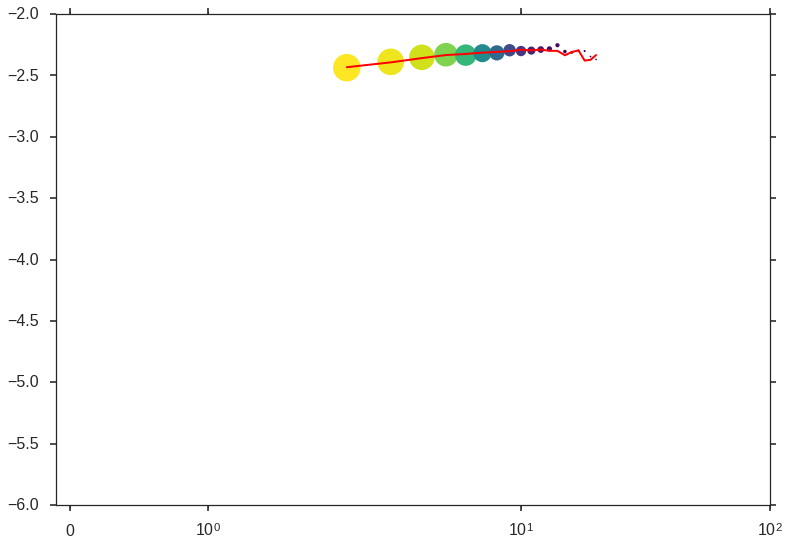

In [33]:
plt.scatter(t.index, logit(t["mean"]["is_self_cite"]), edgecolor="none",
            s=t["len"]["is_self_cite"]/ 1e4,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = plt.cm.get_cmap("viridis"),
            alpha=1, linewidth=3, marker="o")
plt.plot(t.index, logit(t["mean"]["predicted_prob"]), linestyle="-", color="r", lw=2, alpha=1)
plt.xscale("symlog")
plt.xlim([-0.1,100])
plt.ylim([-6,-2])

auth_prev_papers symlog [-0.1, 101] None
auth_prev_papers None ['is_self_cite', 'predicted_prob']
sink_prev_ncites symlog [-0.1, 101] None
sink_prev_ncites None ['is_self_cite', 'predicted_prob']
source_n_mesh_ex linear [-1, 100] None
source_n_mesh_ex None ['is_self_cite', 'predicted_prob']
sink_n_mesh_ex linear [-1, 100] None
sink_n_mesh_ex None ['is_self_cite', 'predicted_prob']
jj_sim linear [-0.1, 101] None
jj_sim None ['is_self_cite', 'predicted_prob']
year_span symlog [-1.1, 51] None
year_span None ['is_self_cite', 'predicted_prob']
source_ncites log [0.9, 201] None
source_ncites None ['is_self_cite', 'predicted_prob']
source_n_authors linear [0.5, 21] None
source_n_authors None ['is_self_cite', 'predicted_prob']


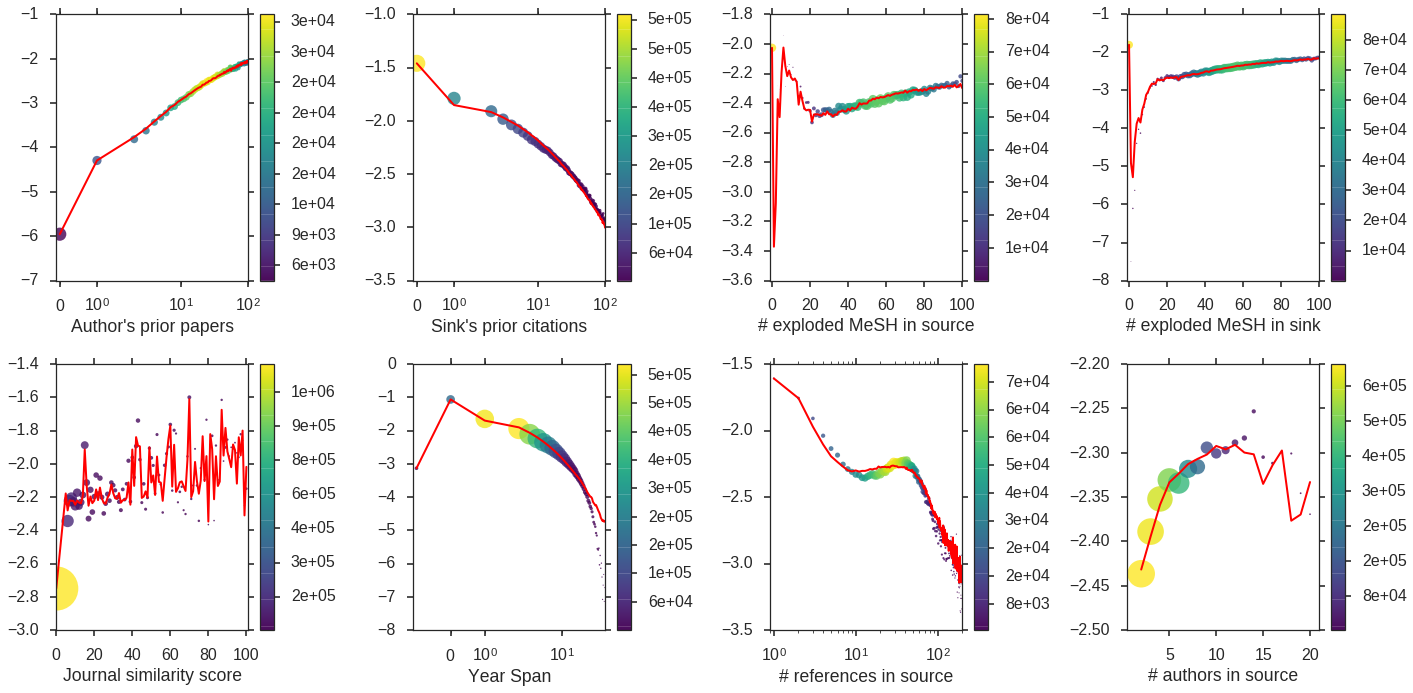

In [34]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('viridis')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4, figsize=(20,10))
ax = ax.flatten()
plot_id = 0
plot_params_dict = {
    "auth_prev_papers": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], None, "Author's prior papers"],
    "sink_prev_ncites": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], None, "Sink's prior citations"],
    "source_n_mesh_ex": [np.array([-0.1] + range(101)), "linear", [-1, 100], [-3.1, -2.3], "# exploded MeSH in source"],
    "sink_n_mesh_ex": [np.array([-0.1] + range(101)), "linear", [-1, 100], [-4, -2], "# exploded MeSH in sink"],
    "jj_sim": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], None, "Journal similarity score"],
    "year_span": [np.array([-10, -1] + range(51)), "symlog", [-1.1, 51], None, "Year Span"],
    "source_ncites": [np.array([-1] + range(201)), "log", [0.9, 201], [-3.5, -1.5], "# references in source"],
    "source_n_authors": [np.array([-0.1] + range(21)), "linear", [0.5,15], [-3.2,-2.8], "# authors in source"]
}

plot_params_dict = {
    "auth_prev_papers": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], None, "Author's prior papers"],
    "sink_prev_ncites": [np.array([-0.1] + range(101)), "symlog", [-0.1, 101], None, "Sink's prior citations"],
    "source_n_mesh_ex": [np.array([-0.1] + range(101)), "linear", [-1, 100], None, "# exploded MeSH in source"],
    "sink_n_mesh_ex": [np.array([-0.1] + range(101)), "linear", [-1, 100], None, "# exploded MeSH in sink"],
    "jj_sim": [np.array([-0.1,0] + range(5,101)), "linear", [-0.1, 101], None, "Journal similarity score"],
    "year_span": [np.array([-10, -1] + range(51)), "symlog", [-1.1, 51], None, "Year Span"],
    "source_ncites": [np.array([-1] + range(201)), "log", [0.9, 201], None, "# references in source"],
    "source_n_authors": [np.array([-0.1] + range(21)), "linear", [0.5,21], None, "# authors in source"]
}


y_feature_col = ["is_self_cite", "predicted_prob"]
xcols = ["auth_prev_papers", "sink_prev_ncites", 
         "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim",
         "year_span", "source_ncites", "source_n_authors"]
for k in xcols:
    bins, xscale, xlims, ylims, xlbl = plot_params_dict[k]
    print k, xscale, xlims, ylims
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var=None,
    bins=bins,
    testing=False)
    #lgd_items = []
    scp = ax[plot_id].scatter(t.index, logit(t["mean"]["is_self_cite"]),
            edgecolor="none",
            s=t["len"]["is_self_cite"]/ 1e4,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = cm, alpha=0.8, linewidth=3, marker="o")
    #yidx = ((t.index >= xlims[0]) & (t.index <= xlims[1]))
    #line, = ax[plot_id].plot(t[yidx].index, logit(t[yidx]["mean"]["predicted_prob"]), linestyle="-", color="r", lw=2, alpha=1)
    line, = ax[plot_id].plot(
        t.index, logit(t["mean"]["predicted_prob"]), linestyle="-", color="r", lw=2, alpha=1)
    #ylims = [logit(t[yidx]["mean"]["is_self_cite"]).min(), logit(t[yidx]["mean"]["is_self_cite"]).max()]
    #lgd_items.append(line)
    cb = plt.colorbar(scp, ax = ax[plot_id], format='%.0e')
    ax[plot_id].set_xlabel(xlbl)
    #ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    ax[plot_id].set_ylim(ylims)
    plot_id += 1
plt.margins(0.1)
#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
"""
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
"""
fig.tight_layout()
plt.savefig("Empirical_vs_Fit_1.temp.%s.pdf" % MODEL_SUFFIX)

## Save model data
V4 - Added square term for author age

In [47]:
MODEL_SUFFIX

'v4.last_author'

In [48]:
X.columns

Index([u'Intercept', u'I(auth_prev_papers == 0)[T.True]',
       u'I(auth_prev_papers == 1)[T.True]', u'C(gender, levels=GENDERS)[T.F]',
       u'C(gender, levels=GENDERS)[T.M]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)

In [49]:
# Bumped version number to v4
with pd.HDFStore("out/Model.%s.h5" % MODEL_SUFFIX, mode="w",) as store:
    store.put("X", X, format="table")
    print "Finished X"
    store.put("y", y, format="table")
    print "Finished y"

Finished X
Finished y


## Testing plots

(-2.5, -2.2)

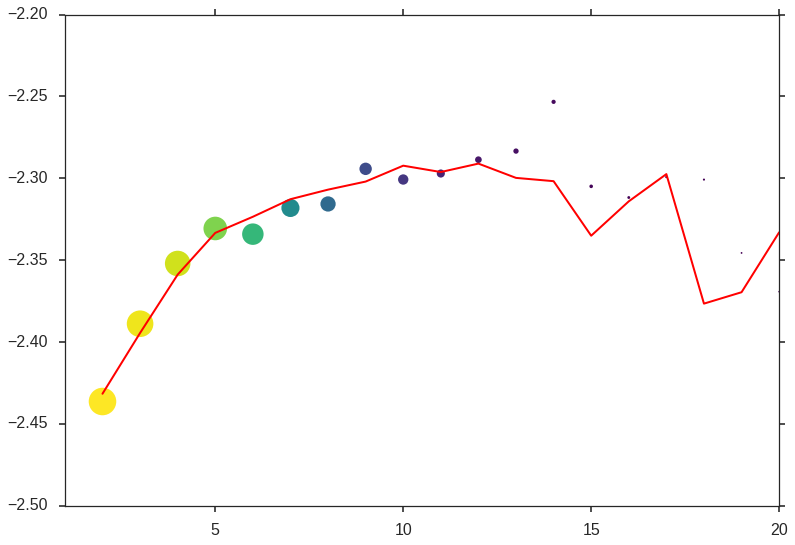

In [36]:
plt.scatter(t.index, logit(t["mean"]["is_self_cite"]), edgecolor="none",
            s=t["len"]["is_self_cite"]/ 1e4,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = plt.cm.get_cmap("viridis"),
            alpha=1, linewidth=3, marker="o")
plt.plot(t.index, logit(t["mean"]["predicted_prob"]), linestyle="-", color="r", lw=2, alpha=1)
plt.xscale("linear")
plt.xlim([1,20])
plt.ylim([-2.5, -2.2])

In [37]:
from matplotlib.colors import SymLogNorm, LogNorm

(-2.5, -2.2)

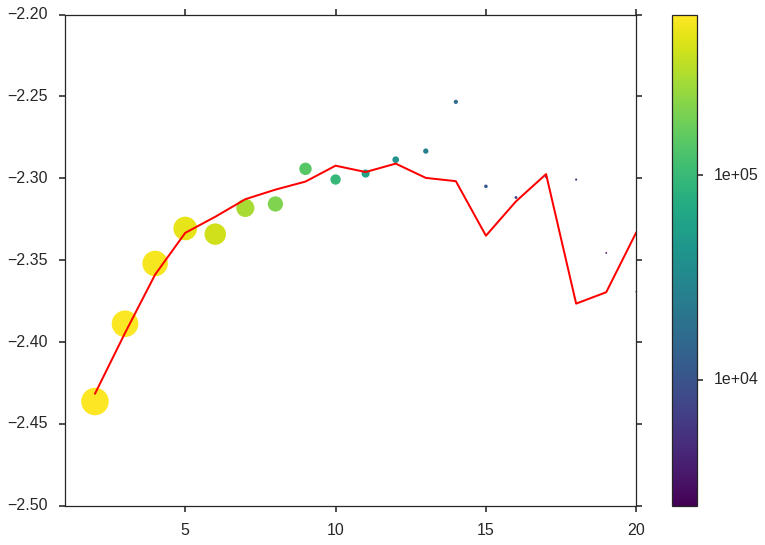

In [46]:
scp = plt.scatter(t.index, logit(t["mean"]["is_self_cite"]), edgecolor="none",
            s=t["len"]["is_self_cite"]/ 1e4,
            c = (t["mean"]["is_self_cite"] * t["len"]["is_self_cite"]),
            cmap = plt.cm.get_cmap("viridis"),
            #norm=SymLogNorm(linthresh=1e-7, linscale=1),
            norm=LogNorm(),
            alpha=1, linewidth=3, marker="o")
cb = plt.colorbar(scp, ax = plt.gca(), format='%.0e')
plt.plot(t.index, logit(t["mean"]["predicted_prob"]), linestyle="-", color="r", lw=2, alpha=1)
plt.xscale("linear")
plt.xlim([1,20])
plt.ylim([-2.5, -2.2])